In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from sklearn.model_selection import train_test_split
from beam_utils import ULA_DFT_codebook,UPA_DFT_codebook,calc_beam_pattern,pow_2_dB,dB_2_pow
import torch
from DL_utils_MISO import BF_Autoencoder
import DeepMIMO
from os.path import exists

In [4]:
scenario = 'Boston5G_28'
activated_BS = 1
random_UE_rotation = False
array_type = 'ULA'

tx_power_dBm = 40
noise_PSD_dB = -161
BW = 50e6
noise_power_dBm = noise_PSD_dB + 10*np.log10(BW) # dBm
measurement_gain = 32.0
measurement_gain_dB = 10*np.log10(measurement_gain)
IA_threshold = -5
measurement_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain
h_NMSE_dB = -np.inf
dataset_split_seed = 7
BS_array_shape = np.array([1,64,1])

In [7]:
scenario = 'Boston5G_28'
ue_row_first = 1
ue_row_last = 1622

parameters = DeepMIMO.default_params()
parameters['dataset_folder'] = 'D:/Github Repositories/DeepMIMO-codes/DeepMIMOv2/Raytracing_scenarios'

parameters['scenario'] = scenario
parameters['num_paths'] = 15
parameters['active_BS'] = [activated_BS]
parameters['user_row_first'] = ue_row_first
parameters['user_row_last'] = ue_row_last
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = BS_array_shape
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'
num_antenna = num_antenna = np.prod(BS_array_shape)

parameters['ue_antenna']['shape'] = np.array([1, 1, 1])
parameters['ue_antenna']['spacing'] = 0.5
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 0

parameters['OFDM_channels'] = 1 # Frequency (OFDM) or time domain channels
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 1
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = BW/1e9
parameters['OFDM']['RX_filter'] = 0

dataset_savefname = './Data/{}_{}x{}x{}.npy'.format(scenario,
                                                BS_array_shape[0],
                                                BS_array_shape[1],
                                                BS_array_shape[2])

if exists(dataset_savefname):
    print('Loading dataset...')
    h = np.load(dataset_savefname,allow_pickle=True)
else:
    print('Generating dataset...')
    dataset = DeepMIMO.generate_data(parameters)
    h = dataset[0]['user']['channel'].squeeze(axis=-1)
    valid_ue_idc = np.array([ue_i for (ue_i,ue_h) in enumerate(h) if not (ue_h==0).all()])
    print('Keep {} out of {} UEs that have valid paths.'.format(len(valid_ue_idc),h.shape[0]))
    h = h[valid_ue_idc]
    np.save(dataset_savefname,h,allow_pickle=True)

if IA_threshold > -np.inf:
    EGT_gain_path = './Data/EGT_gain_{}_BS_{}_BS_array_{}x{}x{}.npy'.format(scenario,
                                                                               activated_BS,
                                                                               BS_array_shape[0],
                                                                               BS_array_shape[1],
                                                                               BS_array_shape[2])
    if exists(EGT_gain_path):
        EGT_gain = np.load(EGT_gain_path,allow_pickle=True)
    else:
        # MRT_gain = np.linalg.norm(h.squeeze(),axis=-1)**2
        EGT_gain = np.power(np.sum(abs(h.squeeze()),axis=1),2)/num_antenna
        np.save(EGT_gain_path,EGT_gain,allow_pickle=True)
    EGT_snr = tx_power_dBm+10*np.log10(EGT_gain)-noise_power_dBm
    reachable_ue = EGT_snr>IA_threshold   
    print('Keep {} out of {} UEs that are above the IA SNR threshold ({} dB).'.format(reachable_ue.sum(),h.shape[0],IA_threshold))    
    h = h[reachable_ue]

norm_factor = np.max(abs(h))
h_scaled = (h.T/norm_factor).T

# Training and testing data:
# --------------------------
train_idc, test_idc = train_test_split(np.arange(h.shape[0]),test_size=0.4)
val_idc, test_idc = train_test_split(test_idc,test_size=0.5)

x_train,x_val,x_test = h_scaled[train_idc],h_scaled[val_idc],h_scaled[test_idc]

torch_x_train = torch.from_numpy(x_train)
torch_x_val = torch.from_numpy(x_val)
torch_x_test = torch.from_numpy(x_test)

Loading dataset...
Keep 77637 out of 105842 UEs that are above the IA SNR threshold (-5 dB).


#### GF (BF loss)

In [12]:
n_probe_arr = np.array([4,8,12,16,20,24,28,32,48])
mode = 'GF'
loss_fn = 'BF_loss' 
num_beams = None
model_savefname_prefix = './Saved_Models/'
GF_BF_loss_vs_nprobe = []
for n_probing_beam in n_probe_arr:
    model = BF_Autoencoder(num_antenna =num_antenna,num_probing_beam = n_probing_beam,
                                noise_power=measurement_noise_power, norm_factor = norm_factor,
                                mode = mode, num_beam = num_beams)
    model_setup_params = ("MISO_{}_BS_{}_{}_"+
                    "{}_{}_Nprobe_{}_"+
                    "{}_antenna").format(scenario,activated_BS,array_type,
                                            mode,loss_fn,
                                            n_probing_beam,num_antenna)
    model_savefname = model_savefname_prefix+model_setup_params+".pt"
    state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
    model.load_state_dict(state_dict_load)
    model.eval()    
    with torch.no_grad():
        beam_pred = model(torch_x_test)
        beam_pred = beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna x 1
    predicted_bf_gain = (abs(h[test_idc] @ beam_pred)**2).squeeze()   
    GF_BF_loss_vs_nprobe.append(predicted_bf_gain)
GF_BF_loss_vs_nprobe = np.array(GF_BF_loss_vs_nprobe)

In [13]:
n_probe_arr = np.array([4,8,12,16,20,24,28,32,48])
mode = 'GF'
loss_fn = 'SPE_loss' 
num_beams = None
model_savefname_prefix = './Saved_Models/'
GF_SPE_loss_vs_nprobe = []
for n_probing_beam in n_probe_arr:
    model = BF_Autoencoder(num_antenna =num_antenna,num_probing_beam = n_probing_beam,
                                noise_power=measurement_noise_power, norm_factor = norm_factor,
                                mode = mode, num_beam = num_beams)
    model_setup_params = ("MISO_{}_BS_{}_{}_"+
                    "{}_{}_Nprobe_{}_"+
                    "{}_antenna").format(scenario,activated_BS,array_type,
                                            mode,loss_fn,
                                            n_probing_beam,num_antenna)
    model_savefname = model_savefname_prefix+model_setup_params+".pt"
    state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
    model.load_state_dict(state_dict_load)
    model.eval()    
    with torch.no_grad():
        beam_pred = model(torch_x_test)
        beam_pred = beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna x 1
    predicted_bf_gain = (abs(h[test_idc] @ beam_pred)**2).squeeze()   
    GF_SPE_loss_vs_nprobe.append(predicted_bf_gain)
GF_SPE_loss_vs_nprobe = np.array(GF_SPE_loss_vs_nprobe)

In [25]:
n_probe_arr = np.array([4,8,12,16,20,24,28,32,48])
mode = 'CB'
oversampling_factor = 2
loss_fn = 'None' 
num_beams = num_antenna*oversampling_factor
DFT_codebook = ULA_DFT_codebook(nseg=num_beams,n_antenna=num_antenna)

model_savefname_prefix = './Saved_Models/'
CB_vs_nprobe = []
for n_probing_beam in n_probe_arr:
    model = BF_Autoencoder(num_antenna =num_antenna,num_probing_beam = n_probing_beam,
                                noise_power=measurement_noise_power, norm_factor = norm_factor,
                                mode = mode, num_beam = num_beams)
    model_setup_params = ("MISO_{}_BS_{}_{}_"+
                    "{}_{}_Nprobe_{}_"+
                    "{}_antenna").format(scenario,activated_BS,array_type,
                                            mode,loss_fn,
                                            n_probing_beam,num_antenna)
    model_savefname = model_savefname_prefix+model_setup_params+".pt"
    state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
    model.load_state_dict(state_dict_load)
    model.eval()    
    with torch.no_grad():
        beam_pred = model(torch_x_test).numpy().argmax(axis=1) 
        beam_pred = DFT_codebook[beam_pred]
        beam_pred = np.expand_dims(beam_pred,axis=-1) # n_batch x num_antenna x 1
    predicted_bf_gain = (abs(h[test_idc] @ beam_pred)**2).squeeze()   
    CB_vs_nprobe.append(predicted_bf_gain)
CB_vs_nprobe = np.array(CB_vs_nprobe)

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
nbeam_arr = np.array([4,8,16,32,64,128])
genie_vs_nbeam = []
for nbeam in nbeam_arr:
    DFT_codebook = ULA_DFT_codebook(nseg=nbeam,n_antenna=num_antenna).T
    dft_bf_gain = abs(h[test_idc] @ DFT_codebook).squeeze()**2
    dft_bf_gain = dft_bf_gain.max(axis=1)
    genie_vs_nbeam.append(dft_bf_gain)
genie_vs_nbeam = np.array(genie_vs_nbeam)

EGT_bfgain = np.power(np.sum(abs(h[test_idc].squeeze()),axis=1),2)/num_antenna

In [24]:
genie_vs_nbeam.shape

(7, 15528)

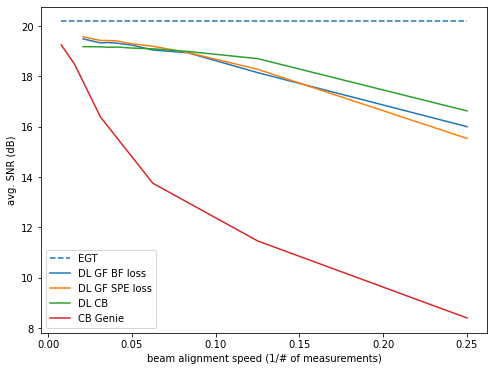

In [35]:
plt.figure(figsize=(8,6))
plt.hlines(tx_power_dBm+pow_2_dB(EGT_bfgain.mean())-noise_power_dBm,xmin=1/128,xmax=1/4,label='EGT',linestyles='dashed')
plt.plot(1/n_probe_arr,tx_power_dBm+pow_2_dB(GF_BF_loss_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL GF BF loss')
plt.plot(1/n_probe_arr,tx_power_dBm+pow_2_dB(GF_SPE_loss_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL GF SPE loss')
plt.plot(1/n_probe_arr,tx_power_dBm+pow_2_dB(CB_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL CB')
plt.plot(1/nbeam_arr,tx_power_dBm+pow_2_dB(genie_vs_nbeam.mean(axis=1))-noise_power_dBm,label='CB Genie')
plt.legend()
plt.xlabel('beam alignment speed (1/# of measurements)')
plt.ylabel('avg. SNR (dB)')
plt.show()


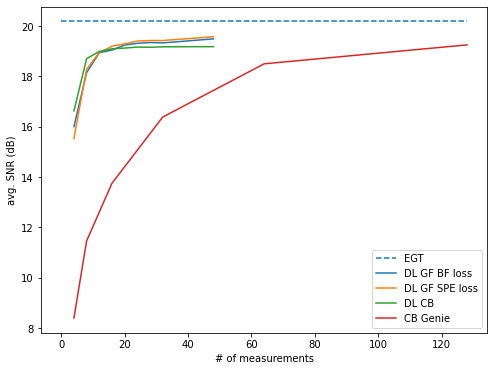

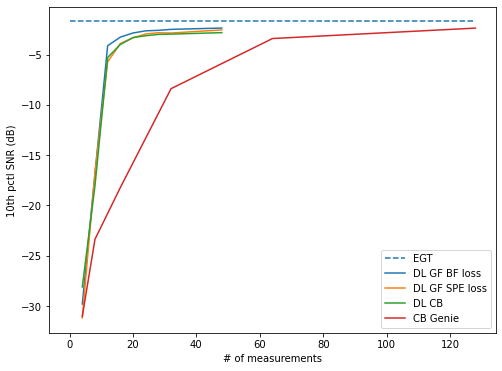

In [56]:
plt.figure(figsize=(8,6))
plt.hlines(tx_power_dBm+pow_2_dB(EGT_bfgain.mean())-noise_power_dBm,xmin=0,xmax=128,label='EGT',linestyles='dashed')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(GF_BF_loss_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL GF BF loss')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(GF_SPE_loss_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL GF SPE loss')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(CB_vs_nprobe.mean(axis=1))-noise_power_dBm,label='DL CB')
plt.plot(nbeam_arr,tx_power_dBm+pow_2_dB(genie_vs_nbeam.mean(axis=1))-noise_power_dBm,label='CB Genie')
plt.legend()
plt.xlabel('# of measurements')
plt.ylabel('avg. SNR (dB)')
plt.show()

pctl = 10
plt.figure(figsize=(8,6))
plt.hlines(tx_power_dBm+pow_2_dB(np.percentile(EGT_bfgain,pctl))-noise_power_dBm,xmin=0,xmax=128,label='EGT',linestyles='dashed')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(np.percentile(GF_BF_loss_vs_nprobe,pctl,axis=1))-noise_power_dBm,label='DL GF BF loss')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(np.percentile(GF_SPE_loss_vs_nprobe,pctl,axis=1))-noise_power_dBm,label='DL GF SPE loss')
plt.plot(n_probe_arr,tx_power_dBm+pow_2_dB(np.percentile(CB_vs_nprobe,pctl,axis=1))-noise_power_dBm,label='DL CB')
plt.plot(nbeam_arr,tx_power_dBm+pow_2_dB(np.percentile(genie_vs_nbeam,pctl,axis=1))-noise_power_dBm,label='CB Genie')
plt.legend()
plt.xlabel('# of measurements')
plt.ylabel('{}th pctl SNR (dB)'.format(pctl))
plt.show()

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


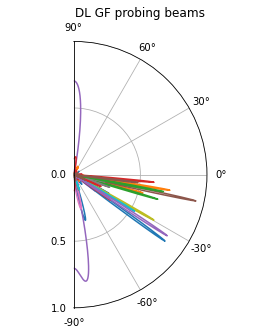

In [57]:
mode = 'GF'
loss_fn = 'BF_loss' 
num_beams = None
model_savefname_prefix = './Saved_Models/'
n_probing_beam = 16
model = BF_Autoencoder(num_antenna =num_antenna,num_probing_beam = n_probing_beam,
                            noise_power=measurement_noise_power, norm_factor = norm_factor,
                            mode = mode, num_beam = num_beams)
model_setup_params = ("MISO_{}_BS_{}_{}_"+
                "{}_{}_Nprobe_{}_"+
                "{}_antenna").format(scenario,activated_BS,array_type,
                                        mode,loss_fn,
                                        n_probing_beam,num_antenna)
model_savefname = model_savefname_prefix+model_setup_params+".pt"
state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
model.load_state_dict(state_dict_load)
probing_codebook = model.get_codebook()

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111,polar=True)
for beam_i, beam in enumerate(probing_codebook.T):
    phi, bf_gain = calc_beam_pattern(beam,phi_min=-np.pi/2,phi_max=np.pi/2,n_antenna=num_antenna)
    ax.plot(phi,bf_gain)
ax.grid(True)
ax.set_rmax(1)
ax.set_rticks([0,0.5, 1])
ax.set_rlabel_position(-90)  
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_theta_zero_location("E")
ax.set_title('DL GF probing beams')
fig.tight_layout()

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


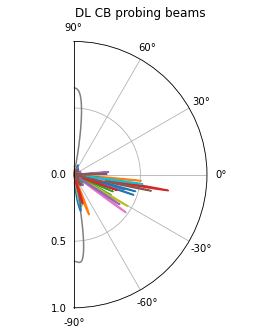

In [58]:
mode = 'CB'
loss_fn = None 
num_beams = 128
model_savefname_prefix = './Saved_Models/'
n_probing_beam = 16
model = BF_Autoencoder(num_antenna =num_antenna,num_probing_beam = n_probing_beam,
                            noise_power=measurement_noise_power, norm_factor = norm_factor,
                            mode = mode, num_beam = num_beams)
model_setup_params = ("MISO_{}_BS_{}_{}_"+
                "{}_{}_Nprobe_{}_"+
                "{}_antenna").format(scenario,activated_BS,array_type,
                                        mode,loss_fn,
                                        n_probing_beam,num_antenna)
model_savefname = model_savefname_prefix+model_setup_params+".pt"
state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
model.load_state_dict(state_dict_load)
probing_codebook = model.get_codebook()

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111,polar=True)
for beam_i, beam in enumerate(probing_codebook.T):
    phi, bf_gain = calc_beam_pattern(beam,phi_min=-np.pi/2,phi_max=np.pi/2,n_antenna=num_antenna)
    ax.plot(phi,bf_gain)
ax.grid(True)
ax.set_rmax(1)
ax.set_rticks([0,0.5, 1])
ax.set_rlabel_position(-90)  
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_theta_zero_location("E")
ax.set_title('DL CB probing beams')
fig.tight_layout()